Before you can plot fig9 and fig10, you need to run dMdv_run.py and dMdt_constant.py to generate relevant fits files 

In [15]:
import numpy as np
import sys
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

sim_name = 'nref11n_nref10f'
dd_name = 'DD2175'
file_root = '%s_%s'%(sim_name, dd_name)
obj_tag = 'cgm-rvir'
b_lim = 20

from foggie.utils import consistency
cmap = consistency.temperature_discrete_cmap
phase_colors = {'all': plt.cm.Greys(0.8), 
                'cold': cmap(0.05), 
                'cool': cmap(0.25), 
                'warm': cmap(0.6), 
                'hot': cmap(0.9)}

gc_ls = '-'
gc_lw = 3

sun_ls = ':'
sun_lw = 3

vmin = -400
vmax = 400

ymin1 = 2e3 #2e3, 2e3 # 2e3
ymax1 = 3e8 #3e7, 1e7 # 3e8

ymin2 = 0.001
ymax2 = 4 # 0.6, 0.4, 4 

fs=14

In [11]:
def read_dMdv_file(filename, phase='cold', b_tag='allb'): 
    if phase not in ['all', 'cold', 'cool', 'warm', 'hot']:
        print('phase has to be all, cold, cooo, warm, hot')
        sys.exit()
    if b_tag not in ['allb', 'lowb', 'highb']: 
        print("b_tag has to be all, lowb, or highb")
        sys.exit()
    
    # file_gc = 'figs/dM_dv/fits/nref11n_nref10f_DD2175_dMdv_%s_halo_center_%s.fits'%(obj_tag, shift)
    data = Table.read(filename, format='fits')
    dv_bins = data['v (km/s)']
    
    if phase=='all':
        dMdv_return = data['dM_%s (Msun/km/s)'%(b_tag)]
    else: 
        dMdv_return = data['dM_%s_%s (Msun/km/s)'%(phase, b_tag)]
        
    return dv_bins, dMdv_return 

def read_dMdt_file(filename, phase='cold', b_tag='allb'): 
    if phase not in ['all', 'cold', 'cool', 'warm', 'hot']:
        print('phase has to be all, cold, cooo, warm, hot')
        sys.exit()
    if b_tag not in ['allb', 'lowb', 'highb']: 
        print("b_tag has to be all, lowb, or highb")
        sys.exit()
    
    # file = 'figs/dM_dt/fits/nref11n_nref10f_DD2175_dMdt_%s_halo_center.fits'%(obj_tag)
    data = Table.read(filename, format='fits')
    dv_bins = data['v (km/s)']
    
    if phase=='all': 
        dMdt_return = data['dMdt_%s (Msun/yr)'%(b_tag)]
    else: 
        dMdt_return = data['dMdt_%s_%s (Msun/yr)'%(phase, b_tag)]
    # let's do a little tweak to the dMdt to make them all positive for better illustration 
    dMdt_return[dv_bins<=0] = np.abs(dMdt_return[dv_bins<=0])
    
    return dv_bins, dMdt_return

### fig9: dMdv from halo center and from off center 

In [41]:
b_tag = 'highb'

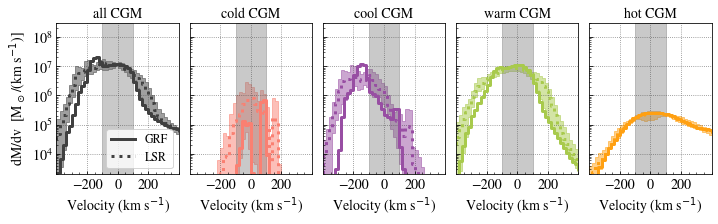

In [42]:
fig = plt.figure(figsize=(10, 3.))
width = 0.17
gap = 0.015

data_dir = 'figs/dM_dv/fits'
for i, phase in enumerate(['all', 'cold', 'cool', 'warm', 'hot']): 
    ##### get data for galactic center #### 
    file_gc = '%s/nref11n_nref10f_DD2175_dMdv_%s_halo_center_b%d.fits'%(data_dir, obj_tag, b_lim)
    vel, dMdv_gc = read_dMdv_file(file_gc, phase=phase, b_tag=b_tag)

    ##### get data from off centers ###### 
    dMdv_sun = []
    shifts = ['0', '45', '90', '135', '180', '225', '270', '315']
    for ideg in shifts: 
        if ideg == '0': 
            file_sun = '%s/%s_dMdv_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
            vel, dMdv_sun_0 = read_dMdv_file(file_sun, phase=phase, b_tag=b_tag)
            dMdv_sun.append(dMdv_sun_0)
        else: 
            file_sun = '%s/%s_dMdv_%s_offcenter_location_b%d_%s.fits'%(data_dir, file_root, obj_tag, b_lim, ideg)
            dMdv_sun.append(read_dMdv_file(file_sun, phase=phase, b_tag=b_tag)[1])
    dMdv_sun = np.asarray(dMdv_sun)
    dMdv_sun_mean = np.mean(dMdv_sun, axis=0)
    dMdv_sun_min = np.min(dMdv_sun, axis=0)
    dMdv_sun_max = np.max(dMdv_sun, axis=0)
    
    ###################################################################
    color = phase_colors[phase]
    ax1 = fig.add_axes([0.07+i*(width+gap), 0.2, width, 0.7])
    ax1.step(vel, dMdv_gc, color=color, linestyle=gc_ls, linewidth=gc_lw, label='GRF')
    ax1.step(vel, dMdv_sun_mean, color=color, linestyle=sun_ls, linewidth=sun_lw, label='LSR')
    ax1.fill_between(vel, dMdv_sun_min, dMdv_sun_max, step="pre", alpha=0.5, color=color)

    ax1.set_yscale('log')
    ax1.set_xlim(vmin, vmax)
    ax1.set_ylim(ymin1, ymax1)
    ax1.minorticks_on()
    if i == 0: 
        ax1.legend(fontsize=fs-2, loc='lower right')
    ax1.fill_between([-100, 100], ymin1, ymax1, color=plt.cm.Greys(0.6), alpha=0.4)
    ax1.set_title(r'%s CGM'%(phase), fontsize=fs)

    ax1.minorticks_on()
    ax1.set_xlim(vmin, vmax)
    ax1.grid(linestyle=':', alpha=0.7, color=plt.cm.Greys(0.8))
    ax1.set_xticks([-200, 0, 200])
    for tick in ax1.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(fs)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(fs)
    ax1.set_xlabel(r'Velocity (km s$^{-1}$)', fontsize=fs)
    
    ax1.tick_params(direction='in', which='both') 
        
    # only need this for the first column 
    if phase == 'all': 
        ax1.set_ylabel(r'dM/dv  [M$_\odot$/(km s$^{-1}$)]', fontsize=fs)
    else: 
        ax1.set_yticklabels([])

fig.savefig('figs/dM_dv/nref11n_nref10f_DD2175_dMdv_%s_allphases_%s.pdf'%(obj_tag, b_tag))

plot the dMdv and dMdt for different phases together 

In [35]:
b_tag = 'allb'

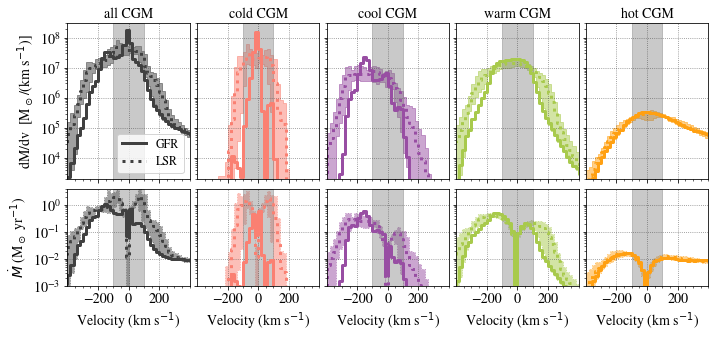

In [36]:
fig = plt.figure(figsize=(10, 4.5))
width = 0.17
gap = 0.01

for i, phase in enumerate(['all', 'cold', 'cool', 'warm', 'hot']): 
    ####################### dMdv data for galactic center #### 
    data_dir = 'figs/dM_dv/fits'
    file_gc = '%s/nref11n_nref10f_DD2175_dMdv_%s_halo_center_b%d.fits'%(data_dir, obj_tag, b_lim)
    vel, dMdv_gc = read_dMdv_file(file_gc, phase=phase, b_tag=b_tag)

    ##### get data from off centers ###### 
    dMdv_sun = []
    shifts = ['0', '45', '90', '135', '180', '225', '270', '315']
    for ideg in shifts: 
        if ideg == '0': 
            file_sun = '%s/%s_dMdv_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
            vel, dMdv_sun_0 = read_dMdv_file(file_sun, phase=phase, b_tag=b_tag)
            dMdv_sun.append(dMdv_sun_0)
        else: 
            file_sun = '%s/%s_dMdv_%s_offcenter_location_b%d_%s.fits'%(data_dir, file_root, obj_tag, b_lim, ideg)
            dMdv_sun.append(read_dMdv_file(file_sun, phase=phase, b_tag=b_tag)[1])
    dMdv_sun = np.asarray(dMdv_sun)
    dMdv_sun_mean = np.mean(dMdv_sun, axis=0)
    dMdv_sun_min = np.min(dMdv_sun, axis=0)
    dMdv_sun_max = np.max(dMdv_sun, axis=0)
    
    ###################### dMdt data #### 
    data_dir = 'figs/dM_dt/fits'
    file_gc = '%s/nref11n_nref10f_DD2175_dMdt_%s_halo_center_b%d.fits'%(data_dir, obj_tag, b_lim)
    vel, dMdt_gc = read_dMdt_file(file_gc, phase=phase, b_tag=b_tag)

    ##### get data from off centers ###### 
    dMdt_sun = []
    shifts = ['0', '45', '90', '135', '180', '225', '270', '315']
    for ideg in shifts: 
        if ideg == '0': 
            file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
            vel, dMdt_sun_0 = read_dMdt_file(file_sun, phase=phase, b_tag=b_tag)
            dMdt_sun.append(dMdt_sun_0)
        else: 
            file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d_%s.fits'%(data_dir, file_root, obj_tag, b_lim, ideg)
            dMdt_sun.append(read_dMdt_file(file_sun, phase=phase, b_tag=b_tag)[1])
    dMdt_sun = np.asarray(dMdt_sun)
    dMdt_sun_mean = np.mean(dMdt_sun, axis=0)
    dMdt_sun_min = np.min(dMdt_sun, axis=0)
    dMdt_sun_max = np.max(dMdt_sun, axis=0)
        
    ###################################################################
    color = phase_colors[phase]
    ax1 = fig.add_axes([0.09+i*(width+gap), 0.46, width, 0.48])
    ax2 = fig.add_axes([0.09+i*(width+gap), 0.13, width, 0.30])
    
    ### plot 
    ax1.step(vel, dMdv_gc, color=color, linestyle=gc_ls, linewidth=gc_lw, label='GFR')
    ax1.step(vel, dMdv_sun_mean, color=color, linestyle=sun_ls, linewidth=sun_lw, label='LSR')
    ax1.fill_between(vel, dMdv_sun_min, dMdv_sun_max, step="pre", alpha=0.5, color=color)

    ax1.set_yscale('log')
    ax1.set_xlim(vmin, vmax)
    ax1.set_xticklabels([])
    ax1.set_ylim(ymin1, ymax1)
    ax1.minorticks_on()
    if i == 0: 
        ax1.legend(fontsize=fs-2, loc='lower right')
    ax1.fill_between([-100, 100], ymin1, ymax1, color=plt.cm.Greys(0.6), alpha=0.4)
    # ax1.text(200, 1e8, fig_tag, fontsize=fs-2)
    ax1.set_title(r'%s CGM'%(phase), fontsize=fs)

    # for the infall rate test 
    ax2.step(vel, dMdt_gc, color=color, linestyle=gc_ls, linewidth=gc_lw, label='wrt gc')
    ax2.step(vel, dMdt_sun_mean, color=color, linestyle=sun_ls, linewidth=sun_lw, label='wrt sun')
    ax2.fill_between(vel, dMdt_sun_min, dMdt_sun_max, color=color, linestyle=sun_ls, step="pre", alpha=0.5)
    # ax2.legend(fontsize=fs-2, loc='upper right')

    ax2.set_ylim(ymin2, ymax2)
    ax2.set_yscale('log')
    ax2.set_xlabel(r'Velocity (km s$^{-1}$)', fontsize=fs)
    ax2.fill_between([-100, 100], ymin2, ymax2, color=plt.cm.Greys(0.6), alpha=0.4)
    
    for ax in [ax1, ax2]: 
        ax.minorticks_on()
        ax.set_xlim(vmin, vmax)
        ax.grid(linestyle=':', alpha=0.7, color=plt.cm.Greys(0.8))
        ax.set_xticks([-200, 0, 200])
        for tick in ax.xaxis.get_major_ticks(): 
            tick.label.set_fontsize(fs)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(fs)
        
    # only need this for the first column 
    if phase == 'all': 
        ax1.set_ylabel(r'dM/dv  [M$_\odot$/(km s$^{-1}$)]', fontsize=fs)
        ax2.set_ylabel(r'$\dot{M}$ (M$_\odot$ yr$^{-1}$)', fontsize=fs)
    else: 
        ax1.set_yticklabels([])
        ax2.set_yticklabels([])

fig.savefig('figs/dM_dt/nref11n_nref10f_DD2175_dMdv_dMdt_%s_allphases_%s.pdf'%(obj_tag, b_tag))
fig.savefig('/Users/Yong/Desktop/save.pdf')

### Calculate dMdt values from halo center and from off centers 

In [28]:
b_tag = 'highb'
for b_tag in ['allb', 'lowb', 'highb']: 
    data_dir = 'figs/dM_dt/fits'

    for i, phase in enumerate(['all', 'cold', 'cool', 'warm', 'hot']): 
        ##### get data for galactic center #### 
        file_gc = '%s/nref11n_nref10f_DD2175_dMdt_%s_halo_center_b%d.fits'%(data_dir, obj_tag, b_lim)
        vel, dMdt_gc = read_dMdt_file(file_gc, phase=phase, b_tag=b_tag)

        ##### get data from off centers ###### 
        dMdt_sun = []
        shifts = ['0', '45', '90', '135', '180', '225', '270', '315']
        for ideg in shifts: 
            if ideg == '0': 
                file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
                vel, dMdt_sun_0 = read_dMdt_file(file_sun, phase=phase, b_tag=b_tag)
                dMdt_sun.append(dMdt_sun_0)
            else: 
                file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d_%s.fits'%(data_dir, file_root, obj_tag, b_lim, ideg)
                dMdt_sun.append(read_dMdt_file(file_sun, phase=phase, b_tag=b_tag)[1])
        dMdt_sun = np.asarray(dMdt_sun)
        dMdt_sun_mean = np.mean(dMdt_sun, axis=0)
        dMdt_sun_min = np.min(dMdt_sun, axis=0)
        dMdt_sun_max = np.max(dMdt_sun, axis=0)
    
        ### now calculate the inflow and outflow rates 
        in_high = vel<-100
        in_low = np.all([vel>=-100, vel<=0], axis=0)
        out_high = vel>100 
        out_low = np.all([vel>0, vel<=100], axis=0)

        f_in_high = dMdt_sun_mean[in_high].sum()
        f_in_low = dMdt_sun_mean[in_low].sum()
        f_out_high = dMdt_sun_mean[out_high].sum()
        f_out_low = dMdt_sun_mean[out_low].sum()
    
        print('%s, %s CGM gas: '%(b_tag, phase))
        print('    v<-100, -100<v<0, 0<v<100, v>100')
        print('    %.2f,   %.2f,     %.2f,    %.2f, Msun/yr'%(f_in_high, f_in_low, f_out_low, f_out_high))

allb, all CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    6.95,   7.13,     6.69,    1.69, Msun/yr
allb, cold CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    0.91,   5.16,     5.51,    0.39, Msun/yr
allb, cool CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    2.52,   0.78,     0.34,    0.06, Msun/yr
allb, warm CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    3.39,   1.14,     0.80,    0.96, Msun/yr
allb, hot CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    0.13,   0.05,     0.04,    0.27, Msun/yr
lowb, all CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    3.14,   6.04,     6.04,    0.86, Msun/yr
lowb, cold CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    0.90,   5.08,     5.39,    0.37, Msun/yr
lowb, cool CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    0.99,   0.49,     0.31,    0.05, Msun/yr
lowb, warm CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    1.23,   0.46,     0.33,    0.41, Msun/yr
lowb, hot CGM gas: 
    v<-100, -100<v<0, 0<v<100, v>100
    0.02,   0.01,  

### Calculate dMdv masses at the high velocity regimes, and here high-velocity is defined as |vlsr|>100 km/s

In [15]:
b_tag = 'lowb'

In [44]:
data_dir = 'figs/dM_dv/fits'
print(b_tag)
for i in range(8): 
    if i == 0:
        # get dM/dv wrt to observer 
        file_sun = '%s/%s_dMdv_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
    else: 
        file_sun = '%s/%s_dMdv_%s_offcenter_location_b%d_%d.fits'%(data_dir, file_root, obj_tag, b_lim, i*45)
    data_sun = Table.read(file_sun, format='fits')
    dv_bins_sun = data_sun['v (km/s)']
    dM_all_sun = data_sun['dM_%s (Msun/km/s)'%(b_tag)]
    dM_cold_sun = data_sun['dM_cold_%s (Msun/km/s)'%(b_tag)]
    dM_cool_sun = data_sun['dM_cool_%s (Msun/km/s)'%(b_tag)]
    dM_warm_sun = data_sun['dM_warm_%s (Msun/km/s)'%(b_tag)]
    dM_hot_sun = data_sun['dM_hot_%s (Msun/km/s)'%(b_tag)]

    # cold, cool, warm, hot gas components at the high-velocity ranges 
    ind_high = np.any([dv_bins_sun<=-100, dv_bins_sun>=100], axis=0)
    cold_high_mass = (dM_cold_sun[ind_high]*20).sum()
    cool_high_mass = (dM_cool_sun[ind_high]*20).sum()
    warm_high_mass = (dM_warm_sun[ind_high]*20).sum()
    hot_high_mass = (dM_hot_sun[ind_high]*20).sum()

    # cold, cool, warm, hot gas at the low-velocity ranges 
    ind_low = np.all([dv_bins_sun>-100, dv_bins_sun<100], axis=0)
    cold_low_mass = (dM_cold_sun[ind_low]*20).sum()
    cool_low_mass = (dM_cool_sun[ind_low]*20).sum()
    warm_low_mass = (dM_warm_sun[ind_low]*20).sum()
    hot_low_mass = (dM_hot_sun[ind_low]*20).sum()

    cold_all_mass = (dM_cold_sun*20).sum()
    cool_all_mass = (dM_cool_sun*20).sum()
    warm_all_mass = (dM_warm_sun*20).sum()
    hot_all_mass = (dM_hot_sun*20).sum()
    
    all_high_mass = cold_high_mass + cool_high_mass + warm_high_mass + hot_high_mass
    all_all_mass = (dM_all_sun*20).sum()

    print('cold, cool, warm, hot HVC: %.1e, %.1e, %.1e, %.1e'%(cold_high_mass, cool_high_mass, 
                                                               warm_high_mass, hot_high_mass))
    print('cold, cool, warm, hot LVC: %.1e, %.1e, %.1e, %.1e'%(cold_low_mass, cool_low_mass, 
                                                               warm_low_mass, hot_low_mass))
    print('high/all frac: %.2f, %.2f, %.2f, %.2f, %.2f\n'%(cold_high_mass/cold_all_mass, 
                                                         cool_high_mass/cool_all_mass, 
                                                         warm_high_mass/warm_all_mass, 
                                                         hot_high_mass/hot_all_mass, 
                                                         all_high_mass/all_all_mass))

highb
cold, cool, warm, hot HVC: 1.1e+07, 7.1e+08, 1.2e+09, 6.6e+07
cold, cool, warm, hot LVC: 7.9e+07, 3.3e+08, 1.5e+09, 4.3e+07
high/all frac: 0.13, 0.69, 0.44, 0.60, 0.50

cold, cool, warm, hot HVC: 5.4e+06, 8.5e+08, 1.3e+09, 6.0e+07
cold, cool, warm, hot LVC: 2.1e+08, 1.8e+08, 1.4e+09, 4.9e+07
high/all frac: 0.02, 0.82, 0.48, 0.55, 0.54

cold, cool, warm, hot HVC: 4.1e+07, 8.3e+08, 1.5e+09, 6.1e+07
cold, cool, warm, hot LVC: 8.6e+07, 2.0e+08, 1.2e+09, 4.7e+07
high/all frac: 0.32, 0.80, 0.56, 0.56, 0.62

cold, cool, warm, hot HVC: 2.2e+07, 7.7e+08, 1.4e+09, 6.1e+07
cold, cool, warm, hot LVC: 3.3e+07, 2.7e+08, 1.3e+09, 4.6e+07
high/all frac: 0.39, 0.74, 0.53, 0.57, 0.58

cold, cool, warm, hot HVC: 2.6e+07, 7.5e+08, 1.2e+09, 7.1e+07
cold, cool, warm, hot LVC: 6.2e+07, 3.1e+08, 1.5e+09, 3.6e+07
high/all frac: 0.29, 0.71, 0.43, 0.66, 0.51

cold, cool, warm, hot HVC: 3.0e+07, 6.8e+08, 1.2e+09, 7.9e+07
cold, cool, warm, hot LVC: 7.6e+07, 3.9e+08, 1.5e+09, 2.8e+07
high/all frac: 0.28, 0.64

### new fig, show the dMdt in offcenter for lowb and high b values 

In [301]:
obj_tag = 'cgm-rvir'
data_dir = 'figs/dM_dt/fits'

labels = ['cold', 'cool', 'warm', 'hot']
colors = [phase_colors['cold'], phase_colors['cool'], 
          phase_colors['warm'], phase_colors['hot']]

In [303]:
## for value wrt sun, lowb values 
lowb_cold_in_sun = np.zeros(8)
lowb_cool_in_sun = np.zeros(8)
lowb_warm_in_sun = np.zeros(8)
lowb_hot_in_sun = np.zeros(8)

lowb_cold_out_sun = np.zeros(8)
lowb_cool_out_sun = np.zeros(8)
lowb_warm_out_sun = np.zeros(8)
lowb_hot_out_sun = np.zeros(8)

b_tag = 'lowb'
for i in range(8): 
    if i == 0: 
        file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
    else: 
        file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d_%d.fits'%(data_dir, file_root, obj_tag, b_lim, i*45)
        
    vel, dMdt_all_sun = read_dMdt_file(file_sun, phase='all', b_tag=b_tag)
    vel, dMdt_cold_sun = read_dMdt_file(file_sun, phase='cold', b_tag=b_tag)
    vel, dMdt_cool_sun = read_dMdt_file(file_sun, phase='cool', b_tag=b_tag)
    vel, dMdt_warm_sun = read_dMdt_file(file_sun, phase='warm', b_tag=b_tag)
    vel, dMdt_hot_sun = read_dMdt_file(file_sun, phase='hot', b_tag=b_tag)
    
    # first, do inflow velocity rate 
    indv_in = vel < 0
    lowb_cold_in_sun[i] = -dMdt_cold_sun[indv_in].sum()
    lowb_cool_in_sun[i] = -dMdt_cool_sun[indv_in].sum()
    lowb_warm_in_sun[i] = -dMdt_warm_sun[indv_in].sum()
    lowb_hot_in_sun[i] = -dMdt_hot_sun[indv_in].sum()

    # then do outflow velocity rate 
    indv_out = vel>0 
    lowb_cold_out_sun[i] = dMdt_cold_sun[indv_out].sum()
    lowb_cool_out_sun[i] = dMdt_cool_sun[indv_out].sum()
    lowb_warm_out_sun[i] = dMdt_warm_sun[indv_out].sum()
    lowb_hot_out_sun[i] = dMdt_hot_sun[indv_out].sum()

In [304]:
## for value wrt sun, lowb values 
highb_cold_in_sun = np.zeros(8)
highb_cool_in_sun= np.zeros(8)
highb_warm_in_sun= np.zeros(8)
highb_hot_in_sun = np.zeros(8)

highb_cold_out_sun= np.zeros(8)
highb_cool_out_sun= np.zeros(8)
highb_warm_out_sun= np.zeros(8)
highb_hot_out_sun = np.zeros(8)

b_tag = 'highb'
for i in range(8): 
    if i == 0: 
        file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
    else: 
        file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d_%d.fits'%(data_dir, file_root, obj_tag, b_lim, i*45)
        
    vel, dMdt_all_sun = read_dMdt_file(file_sun, phase='all', b_tag=b_tag)
    vel, dMdt_cold_sun = read_dMdt_file(file_sun, phase='cold', b_tag=b_tag)
    vel, dMdt_cool_sun = read_dMdt_file(file_sun, phase='cool', b_tag=b_tag)
    vel, dMdt_warm_sun = read_dMdt_file(file_sun, phase='warm', b_tag=b_tag)
    vel, dMdt_hot_sun = read_dMdt_file(file_sun, phase='hot', b_tag=b_tag)
    
    # first, do inflow velocity rate 
    indv_in = vel < 0
    highb_cold_in_sun[i] = -dMdt_cold_sun[indv_in].sum()
    highb_cool_in_sun[i] = -dMdt_cool_sun[indv_in].sum()
    highb_warm_in_sun[i] = -dMdt_warm_sun[indv_in].sum()
    highb_hot_in_sun[i] = -dMdt_hot_sun[indv_in].sum()

    # then do outflow velocity rate 
    indv_out = vel>0 
    highb_cold_out_sun[i] = dMdt_cold_sun[indv_out].sum()
    highb_cool_out_sun[i] = dMdt_cool_sun[indv_out].sum()
    highb_warm_out_sun[i] = dMdt_warm_sun[indv_out].sum()
    highb_hot_out_sun[i] = dMdt_hot_sun[indv_out].sum()

In [305]:
arrs = [lowb_cold_in_sun, lowb_cool_in_sun, lowb_warm_in_sun, lowb_hot_in_sun]
lowb_in_sun_mean = np.mean(arrs, axis=1)
lowb_in_sun_min = np.min(arrs, axis=1)
lowb_in_sun_max = np.max(arrs, axis=1)
lowb_in_sun_std = np.std(arrs, axis=1)

arrs = [lowb_cold_out_sun, lowb_cool_out_sun, lowb_warm_out_sun, lowb_hot_out_sun]
lowb_out_sun_mean = np.mean(arrs, axis=1)
lowb_out_sun_min = np.min(arrs, axis=1)
lowb_out_sun_max = np.max(arrs, axis=1)
lowb_out_sun_std = np.std(arrs, axis=1)

arrs = [highb_cold_in_sun, highb_cool_in_sun, highb_warm_in_sun, highb_hot_in_sun]
highb_in_sun_mean = np.mean(arrs, axis=1)
highb_in_sun_min = np.min(arrs, axis=1)
highb_in_sun_max = np.max(arrs, axis=1)
highb_in_sun_std = np.std(arrs, axis=1)

arrs = [highb_cold_out_sun, highb_cool_out_sun, highb_warm_out_sun, highb_hot_out_sun]
highb_out_sun_mean = np.mean(arrs, axis=1)
highb_out_sun_min = np.min(arrs, axis=1)
highb_out_sun_max = np.max(arrs, axis=1)
highb_out_sun_std = np.std(arrs, axis=1)

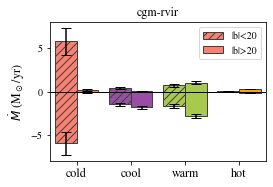

In [306]:
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(4, 2.7))
barlist1 = ax.bar(x - width/2, lowb_in_sun_mean, width, label='|b|<20', hatch='///',
                  color=colors, edgecolor=gray, yerr=lowb_in_sun_std, ecolor='black', capsize=5)
barlist2 = ax.bar(x - width/2, lowb_out_sun_mean, width, label=None, hatch='///',
                  color=colors, edgecolor=gray, yerr=lowb_out_sun_std, ecolor='black', capsize=5)

barlist3 = ax.bar(x + width/2, highb_in_sun_mean, width, label='|b|>20', 
                  color=colors, edgecolor=gray, yerr=highb_in_sun_std, ecolor='black', capsize=5)
barlist4 = ax.bar(x + width/2, highb_out_sun_mean, width, label=None, 
                  color=colors, edgecolor=gray, yerr=highb_out_sun_std, ecolor='black', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\dot{M}$ (M$_\odot$/yr)', fontsize=fs)
ax.set_title(obj_tag, fontsize=fs)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=fs-2)

xmin = -0.5
xmax = len(labels)-0.5
ax.set_xlim(xmin, xmax)
# ax.set_yscale('symlog')
ax.hlines(0, xmin, xmax, linestyle='-', lw=1)
# ax.minorticks_on()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fs)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fs-2)
fig.tight_layout()

if obj_tag == 'cgm-rvir':
    ax.set_ylim(-8, 8)
else: 
    ax.set_ylim(-0.42, 0.42)

plt.show()
fig.savefig('figs/dM_dt/flux_lsr_hist_lowb_highb_%s.pdf'%(obj_tag))

### fig10, Mdt for gas in different phases, and averaged over 8 locations, compare then to those seen wrt Galactic center, and only do this for high latitude gas because that's what observationally assessible

In [242]:
obj_tag = 'cgm-15kpc'
b_tag = 'highb'
data_dir = 'figs/dM_dt/fits'

In [243]:
## for gc values 
file_gc = '%s/%s_dMdt_%s_halo_center_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
vel, dMdt_all_gc = read_dMdt_file(file_gc, phase='all', b_tag=b_tag)
vel, dMdt_cold_gc = read_dMdt_file(file_gc, phase='cold', b_tag=b_tag)
vel, dMdt_cool_gc = read_dMdt_file(file_gc, phase='cool', b_tag=b_tag)
vel, dMdt_warm_gc = read_dMdt_file(file_gc, phase='warm', b_tag=b_tag)
vel, dMdt_hot_gc = read_dMdt_file(file_gc, phase='hot', b_tag=b_tag)

# first, do inflow velocity rate 
indv_in = vel < 0
cold_in_gc = -dMdt_cold_gc[indv_in].sum()
cool_in_gc = -dMdt_cool_gc[indv_in].sum()
warm_in_gc = -dMdt_warm_gc[indv_in].sum()
hot_in_gc = -dMdt_hot_gc[indv_in].sum()

# then do outflow velocity rate 
indv_out = vel>0 
cold_out_gc = dMdt_cold_gc[indv_out].sum()
cool_out_gc = dMdt_cool_gc[indv_out].sum()
warm_out_gc = dMdt_warm_gc[indv_out].sum()
hot_out_gc = dMdt_hot_gc[indv_out].sum()

In [244]:
## for value wrt sun 
cold_in_sun, cool_in_sun, warm_in_sun, hot_in_sun = [], [], [], []
cold_out_sun, cool_out_sun, warm_out_sun, hot_out_sun = [], [], [], []

for i in range(8): 
    if i == 0: 
        file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d.fits'%(data_dir, file_root, obj_tag, b_lim)
    else: 
        file_sun = '%s/%s_dMdt_%s_offcenter_location_b%d_%d.fits'%(data_dir, file_root, obj_tag, b_lim, i*45)
        
    vel, dMdt_all_sun = read_dMdt_file(file_sun, phase='all', b_tag=b_tag)
    vel, dMdt_cold_sun = read_dMdt_file(file_sun, phase='cold', b_tag=b_tag)
    vel, dMdt_cool_sun = read_dMdt_file(file_sun, phase='cool', b_tag=b_tag)
    vel, dMdt_warm_sun = read_dMdt_file(file_sun, phase='warm', b_tag=b_tag)
    vel, dMdt_hot_sun = read_dMdt_file(file_sun, phase='hot', b_tag=b_tag)
    
    # first, do inflow velocity rate 
    indv_in = vel < 0
    cold_in_sun.append(-dMdt_cold_sun[indv_in].sum())
    cool_in_sun.append(-dMdt_cool_sun[indv_in].sum())
    warm_in_sun.append(-dMdt_warm_sun[indv_in].sum())
    hot_in_sun.append(-dMdt_hot_sun[indv_in].sum())

    # then do outflow velocity rate 
    indv_out = vel>0 
    cold_out_sun.append(dMdt_cold_sun[indv_out].sum())
    cool_out_sun.append(dMdt_cool_sun[indv_out].sum())
    warm_out_sun.append(dMdt_warm_sun[indv_out].sum())
    hot_out_sun.append(dMdt_hot_sun[indv_out].sum())

In [245]:
gc_color = plt.cm.Greys(0.6)
sun_color = plt.cm.Oranges(0.5)
fs = 12

In [246]:
labels = ['cold', 'cool', 'warm', 'hot']
colors = [phase_colors['cold'], phase_colors['cool'], 
          phase_colors['warm'], phase_colors['hot']]
in_gc = [cold_in_gc, cool_in_gc, warm_in_gc, hot_in_gc]
in_sun = [np.mean(cold_in_sun), np.mean(cool_in_sun), np.mean(warm_in_sun), np.mean(hot_in_sun)]
in_sun_min = [np.min(cold_in_sun), np.min(cool_in_sun), np.min(warm_in_sun), np.min(hot_in_sun)]
in_sun_max = [np.max(cold_in_sun), np.max(cool_in_sun), np.max(warm_in_sun), np.max(hot_in_sun)]
in_sun_std = [np.std(cold_in_sun), np.std(cool_in_sun), np.std(warm_in_sun), np.std(hot_in_sun)]

out_gc = [cold_out_gc, cool_out_gc, warm_out_gc, hot_out_gc]
out_sun = [np.mean(cold_out_sun), np.mean(cool_out_sun), np.mean(warm_out_sun), np.mean(hot_out_sun)]
out_sun_min = [np.min(cold_out_sun), np.min(cool_out_sun), np.min(warm_out_sun), np.min(hot_out_sun)]
out_sun_max = [np.max(cold_out_sun), np.max(cool_out_sun), np.max(warm_out_sun), np.max(hot_out_sun)]
out_sun_std = [np.std(cold_out_sun), np.std(cool_out_sun), np.std(warm_out_sun), np.std(hot_out_sun)]

In [247]:
print(b_tag, obj_tag)
for i in range(4):
    a = in_gc[i]+out_gc[i]
    b = in_sun[i]+out_sun[i]
    c = b/a
    d = in_sun[i]/in_gc[i]
    e = out_sun[i]/out_gc[i]
    print('%4s: %.2f, %.2f, ratio=%.1f (all), %.1f (in), %.1f (in)'%(labels[i], a, b, c, d, e))

highb cgm-15kpc
cold: -0.00, 0.02, ratio=-56.5 (all), 82.4 (in), inf (in)
cool: -0.01, -0.03, ratio=2.5 (all), 2.7 (in), 4395.2 (in)
warm: -0.22, -0.21, ratio=0.9 (all), 0.9 (in), 0.6 (in)
 hot: -0.00, -0.02, ratio=9.7 (all), 0.9 (in), 0.6 (in)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [248]:
b_tag, in_gc[1], in_sun[1]

('highb', -0.010417601300769843, -0.027791878727210617)

In [249]:
print(b_tag, obj_tag)
for i in range(4):
    a = in_gc[i]+out_gc[i]
    b = in_sun[i]+out_sun[i]
    c = b/a
    d = in_sun[i]/in_gc[i]
    e = out_sun[i]/out_gc[i]
    print('%4s: %.2f, %.2f, ratio=%.1f (all), %.1f (in), %.1f (in)'%(labels[i], a, b, c, d, e))

highb cgm-15kpc
cold: -0.00, 0.02, ratio=-56.5 (all), 82.4 (in), inf (in)
cool: -0.01, -0.03, ratio=2.5 (all), 2.7 (in), 4395.2 (in)
warm: -0.22, -0.21, ratio=0.9 (all), 0.9 (in), 0.6 (in)
 hot: -0.00, -0.02, ratio=9.7 (all), 0.9 (in), 0.6 (in)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


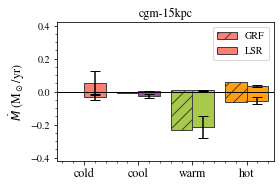

In [250]:
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(4, 2.7))
gray = plt.cm.Greys(0.8)
barlist1 = ax.bar(x - width/2, in_gc, width, label='GRF', 
                  color=colors, hatch='//', edgecolor=gray)
barlist2 = ax.bar(x - width/2, out_gc, width, label=None, 
                  color=colors, hatch='//', edgecolor=gray)

barlist3 = ax.bar(x + width/2, in_sun, width, label='LSR', 
                  color=colors, edgecolor=gray, yerr=in_sun_std, ecolor='black', capsize=5)
barlist4 = ax.bar(x + width/2, out_sun, width, label=None, 
                  color=colors, edgecolor=gray, yerr=out_sun_std, ecolor='black', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\dot{M}$ (M$_\odot$/yr)', fontsize=fs)
ax.set_title(obj_tag, fontsize=fs)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=fs-2)

xmin = -0.5
xmax = len(labels)-0.5
ax.set_xlim(xmin, xmax)
# ax.set_yscale('symlog')
ax.hlines(0, xmin, xmax, linestyle='-', lw=1)
if obj_tag == 'cgm-rvir':
    ax.set_ylim(-8, 8)
else: 
    ax.set_ylim(-0.42, 0.42)
# ax.minorticks_on()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fs)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fs-2)
fig.tight_layout()
ax.minorticks_on()

plt.show()
fig.savefig('figs/dM_dt/flux_grf_lsr_hist_%s_%s.pdf'%(obj_tag, b_tag))